# Ensemble Heteroscedastic Regression Demo

#### Import Statements

In [1]:
import sys
sys.path.append("../../")

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

In [4]:
from uq360.algorithms.ensemble_heteroscedastic_regression import EnsembleHeteroscedasticRegression
from uq360.algorithms.heteroscedastic_regression import HeteroscedasticRegression
from uq360.metrics import picp, mpiw, compute_regression_metrics
from uq360.metrics import UncertaintyCharacteristicsCurve as ucc

In [5]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import torch

#### Load Boston Housing Prices Dataset

In [6]:
house_prices_dataset = datasets.load_boston()
house_prices_df = pd.DataFrame(house_prices_dataset['data'])
house_prices_df.columns = house_prices_dataset['feature_names']

all_features = ['RM','CRIM','PTRATIO', 'DIS']
X = house_prices_df[all_features].values
y = house_prices_dataset['target']

#### Train test split of the dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Text(0.5, 1.0, 'Training data')

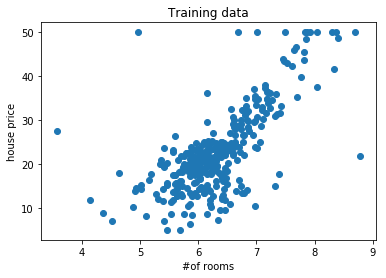

In [8]:
plt.scatter(X_train[:,0], y_train)
plt.xlabel('#of rooms')
plt.ylabel('house price')
plt.title('Training data')

In [9]:
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

### Train Ensemble of Heteroscedastic Regressions

In [10]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# define config for Heteroscedastic Regression
config_HR = {"num_features": X_train.shape[1], "num_outputs": y_train.shape[1], "num_hidden": 50, "batch_size": 32, "num_epochs": 50,
                  "lr": 0.001}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

HR_kwargs = {"model_type":'mlp',
                                   "config": config_HR,
                                   "device": device}

#define config for ensemble of Heteroscedastic Regression
config = {"num_models": 5, 
          "model_kwargs":HR_kwargs, }

uq_model = EnsembleHeteroscedasticRegression(model_type='ensembleheteroscedasticregression', 
                                             config=config, 
                                             device=device)

In [11]:
uq_model = uq_model.fit(X_train, y_train)


Training model 0

Epoch: 0, loss = 1.459425965944926
Epoch: 1, loss = 1.2974590311447778
Epoch: 2, loss = 1.1947528372208278
Epoch: 3, loss = 1.123661324381828
Epoch: 4, loss = 1.070436492562294
Epoch: 5, loss = 1.027777373790741
Epoch: 6, loss = 0.9917417267958323
Epoch: 7, loss = 0.9600538512070973
Epoch: 8, loss = 0.9311446895202
Epoch: 9, loss = 0.9038868645826975
Epoch: 10, loss = 0.8776373863220216
Epoch: 11, loss = 0.852043315768242
Epoch: 12, loss = 0.82683128118515
Epoch: 13, loss = 0.8017907192309699
Epoch: 14, loss = 0.776911124587059
Epoch: 15, loss = 0.7522002359231313
Epoch: 16, loss = 0.728042721748352
Epoch: 17, loss = 0.7043740202983221
Epoch: 18, loss = 0.6817639420429867
Epoch: 19, loss = 0.6601356491446495
Epoch: 20, loss = 0.6401551167170207
Epoch: 21, loss = 0.6218055884043375
Epoch: 22, loss = 0.6054740746816
Epoch: 23, loss = 0.590736210346222
Epoch: 24, loss = 0.577766587336858
Epoch: 25, loss = 0.5663900921742121
Epoch: 26, loss = 0.5563266575336456
Epoch: 27

In [12]:
y_mean, y_lower, y_upper = uq_model.predict(X_test)
y_mean, y_lower, y_upper = scaler_y.inverse_transform(y_mean), scaler_y.inverse_transform(y_lower), scaler_y.inverse_transform(y_upper)
X_test = scaler_X.inverse_transform(X_test)

In [13]:
pred_dict = {'rooms': X_test[:,0],
             'y': y_test[:,0],
             'y_mean': y_mean[:,0],
             'y_upper': y_upper[:,0],
             'y_lower': y_lower[:,0]
            }

pred_df = pd.DataFrame(data=pred_dict)

pred_df_sorted = pred_df.sort_values(by='rooms')

Text(0.5, 1.0, 'Test data PICP: 0.93 MPIW: 17.10')

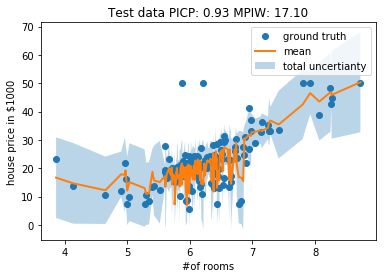

In [14]:
plt.plot(pred_df_sorted['rooms'], pred_df_sorted['y'], 'o', label='ground truth')
plt.plot(pred_df_sorted['rooms'], pred_df_sorted['y_mean'], '-', lw=2, label='mean')
plt.fill_between(pred_df_sorted['rooms'],
                         pred_df_sorted['y_upper'],
                         pred_df_sorted['y_lower'],
                         alpha=0.3, label='total uncertianty')
plt.legend()
plt.xlabel('#of rooms')
plt.ylabel('house price in $1000')
plt.title('Test data PICP: {:.2f} MPIW: {:.2f}'.format(
    picp(y_test, y_lower, y_upper),
    mpiw(y_lower, y_upper))      
         )

#### Let us now plot the AUUCC

In [15]:
def form_D(yhat, zhatl, zhatu):
    # a handy routine to format data as needed by the UCC fit() method
    D = np.zeros([yhat.shape[0],3])
    D[:, 0] = yhat
    D[:, 1] = zhatl
    D[:, 2] = zhatu
    return D

In [16]:
# form matrix for ucc:
X_for_ucc = form_D(y_mean[:,0], y_mean[:,0] - y_lower[:,0], y_upper[:,0] - y_mean[:,0])

# create an instance of ucc and fit data
u = ucc()
u.fit(X_for_ucc, y_test[:,0])

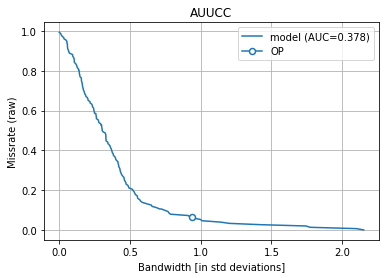

AUUCC is 0.38, OP = (0.10, 0.07)


In [17]:
u.set_coordinates(x_axis_name='bandwidth', y_axis_name='missrate', normalize=True)
auucc, op_info = u.plot_UCC(titlestr=('AUUCC'))
print("AUUCC is %.2f, OP = (%.2f, %.2f)" % (auucc, op_info[0]/op_info[2], op_info[1]))